In [9]:
import pandas as pd

In [10]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")

In [11]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


## Clean data

In [12]:
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

In [13]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda t: t.total_seconds() / 60)

In [14]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [15]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

## Preprocessing

In [12]:
from sklearn.feature_extraction import DictVectorizer

In [13]:
dv = DictVectorizer()

In [16]:
train_dicts = df[categorical + numerical].to_dict(orient="records")

In [ ]:
train_dicts

In [18]:
X_train = dv.fit_transform(train_dicts)

In [19]:
X_train

<2898906x3 sparse matrix of type '<class 'numpy.float64'>'
	with 8696718 stored elements in Compressed Sparse Row format>

In [20]:
target = 'duration'
y_train = df[target].values

In [22]:
from sklearn.linear_model import LinearRegression

In [25]:
model = LinearRegression()

In [35]:
model = model.fit(X_train, y_train)

In [36]:
y_pred = model.predict(X_train)

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_9634/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_9634/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level fun

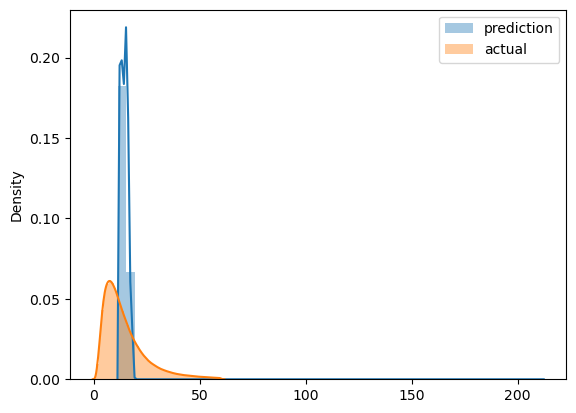

In [38]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [41]:
from sklearn.metrics import mean_squared_error

In [43]:
print("mse: ", mean_squared_error(y_train, y_pred))
print("rmse: ", mean_squared_error(y_train, y_pred, squared=False))

mse:  100.87405816937799
rmse:  10.043607826342981
